This notebook denotes light workflow of using pretrained BERT transformer for classification purposes.
To understand how BERT (and transformers in general) works is not that easy. On the other hand its using (so called) fine-tunnning is not that difficult. BERT's output consists of 
1) Vector of features that should encode information about full document - this is usually used for classification.  
2) Vectors of embeddings for all words from document - this could be used for other tasks (QaA, ...)

Data I have are about classification of questions asked on Quora to sincere and insincere:  
https://www.kaggle.com/c/quora-insincere-questions-classification/overview

Since I am playing with this data after end of the competition, it is quite useless to perform full cross-validation on full training data (1.3M+) and from the same reason it is not necessary to score the competition's test set.
I am using only subset of training data for demonstration.

Competition's evaluation metric was F1 score. Highest F1 score was achieved after 2 epoch of BERT's trianing.

In [24]:
import transformers
from transformers import BertModel, BertTokenizer

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold, KFold

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from wordcloud import WordCloud
import gc

%run auxiliary_functions.py

In [5]:
data = pd.read_csv('E:\\QUORA\\train.csv')
train = data.head(200000)
valid = data.tail(50000)

del data
gc.collect()

90

## Target distribution

Mean target in train data: 0.061805


<AxesSubplot:>

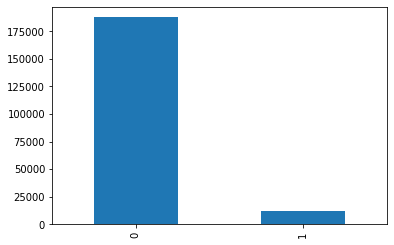

In [6]:
print(f"Mean target in train data: {train['target'].mean()}")

train['target'].value_counts().plot(kind = 'bar')    

## Wordclouds for sincere and insincere questions

In [7]:
full_string0 = ''.join(train[train['target'] == 0]['question_text'])
wordcloud0 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(full_string0) 

full_string1 = ''.join(train[train['target'] == 1]['question_text'])
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(full_string1) 

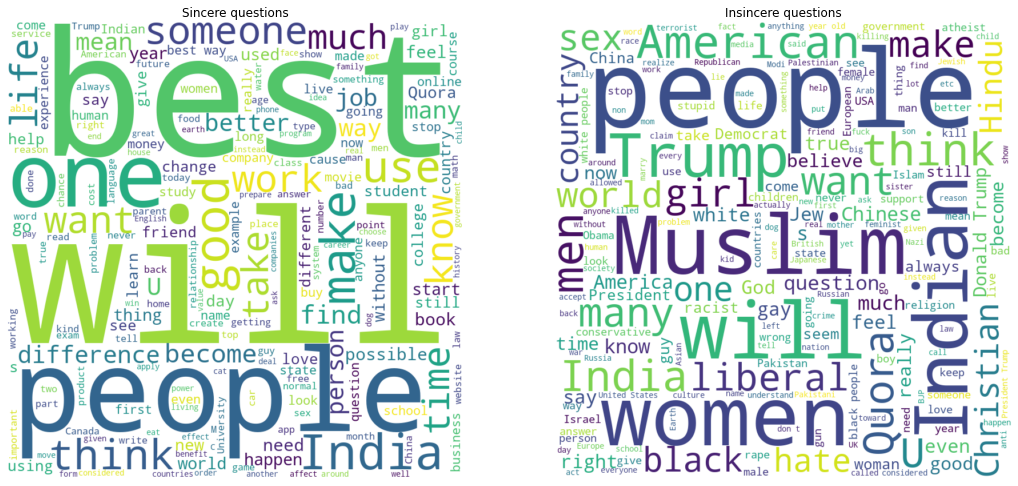

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18, 18))
ax1.imshow(wordcloud0, interpolation = 'bilinear') 
ax1.axis("off")
ax1.set_title('Sincere questions')
ax2.imshow(wordcloud1, interpolation = 'bilinear') 
ax2.axis("off")
ax2.set_title('Insincere questions')

plt.show()


## Bert's tokenization

Bert has its own pretrained word-piece tokenizer, let's see how it works.

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [10]:
print('Examined question:')
print(train['question_text'][4])
print('')

tok = tokenizer.encode_plus(train['question_text'][4],
                           add_special_tokens = True,
                           return_attention_mask = False,
                           return_token_type_ids = False)

print('Pretrained tokens ids:')
print(tok['input_ids'])

print('Original tokens')
print(tokenizer.convert_ids_to_tokens(tok['input_ids']))

Examined question:
Can I convert montra helicon D to a mountain bike by just changing the tyres?

Pretrained tokens ids:
[101, 2825, 146, 10454, 19863, 4487, 1119, 8031, 1320, 141, 1106, 170, 3231, 8295, 1118, 1198, 4787, 1103, 189, 19168, 136, 102]
Original tokens
['[CLS]', 'Can', 'I', 'convert', 'mon', '##tra', 'he', '##lic', '##on', 'D', 'to', 'a', 'mountain', 'bike', 'by', 'just', 'changing', 'the', 't', '##yres', '?', '[SEP]']


#### Distribution of BERT's tokens

According to the distribution of tokens in questions we will set maximum length of the question.

99 pct quantile: 52.0
Mean: 18.296945
Median: 16.0
Max: 512


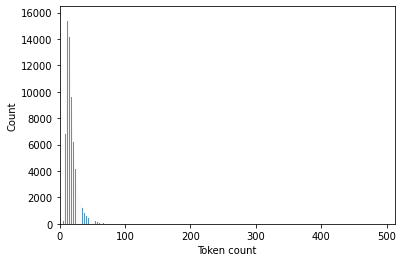

In [13]:
number_of_tokens(tokenizer, train['question_text'])

## Model Training

Data loaded
-----------------------------------
Epoch 0/3
Train stats:
Loss: 0.109597
Acc: 0.957105
Num_corrects: 191421/ 200000 
Precision: 0.698468
Recall: 0.538387
F1: 0.608068

Valid stats:
Loss: 0.100371
Acc: 0.95958
Num_corrects: 47979/ 50000 
Precision: 0.719572
Recall: 0.566526
F1: 0.633943
-----------------------------------
Epoch 1/3
Train stats:
Loss: 0.075528
Acc: 0.969735
Num_corrects: 193947/ 200000 
Precision: 0.767017
Recall: 0.73295
F1: 0.749597

Valid stats:
Loss: 0.102658
Acc: 0.9601
Num_corrects: 48005/ 50000 
Precision: 0.685675
Recall: 0.653933
F1: 0.669428
-----------------------------------
Epoch 2/3
Train stats:
Loss: 0.044897
Acc: 0.98313
Num_corrects: 196626/ 200000 
Precision: 0.859221
Recall: 0.869509
F1: 0.864335

Valid stats:
Loss: 0.126034
Acc: 0.95816
Num_corrects: 47908/ 50000 
Precision: 0.694651
Recall: 0.575915
F1: 0.629735


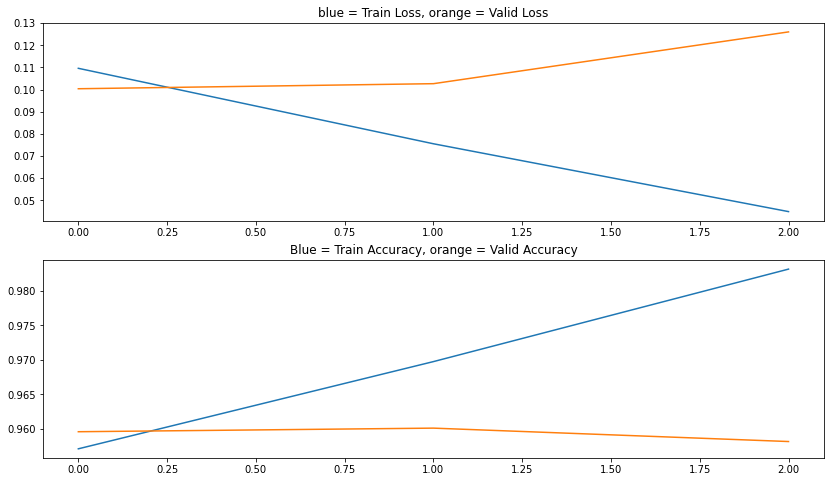

In [26]:
n_classes = 2

MAX_LEN = 50

epochs = 3

train_data = quora_dataset(train, tokenizer, MAX_LEN, n_classes)    
valid_data = quora_dataset(valid, tokenizer, MAX_LEN, n_classes) 

train_loader = DataLoader(train_data, batch_size=32, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle = True)
print('Data loaded')
    
model = network(n_classes, PRE_TRAINED_MODEL_NAME)
model = model.to(device)
    
#loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.cuda()
    
    
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    
train_model(model, loss_function, optimizer, epochs, n_classes, train_loader, valid_loader,
            train_data, valid_data, device)

It looks like 2 epochs of BERT are enought for BERT's fine-tunning. After that models Starts to overfit. In the competition, more than 0.75 F1 score was achieved. So there is quite huge gap between our score from second epoch. On the other hand there is quite huge space for improvement. i haven't done any data preprocessing. Training was done from less than 1/6 of the training data. Also after BERT's layer I put already classification layer, but maybe more complex model after BERT's layer would perform better.